# OpenFinGuard — Exploratory Data Analysis (EDA)

## 1. Objective of This EDA


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)


In [3]:
users = pd.read_csv("../data/raw/users.csv", parse_dates=["account_open_date"])
cards = pd.read_csv("../data/raw/credit_cards.csv", parse_dates=["card_open_date"])
cycles = pd.read_csv(
    "../data/raw/billing_cycles.csv",
    parse_dates=["cycle_start_date", "cycle_end_date", "due_date"]
)


In [4]:
users.head(), users.shape
cards.head(), cards.shape
cycles.head(), cycles.shape


(  billing_cycle_id card_id cycle_start_date cycle_end_date statement_date  \
 0         card_1_0  card_1       2026-01-02     2026-02-01     2026-02-02   
 1         card_1_1  card_1       2025-12-03     2026-01-02     2026-01-03   
 2         card_1_2  card_1       2025-11-03     2025-12-03     2025-12-04   
 3         card_1_3  card_1       2025-10-04     2025-11-03     2025-11-04   
 4         card_1_4  card_1       2025-09-04     2025-10-04     2025-10-05   
 
     due_date  total_due  minimum_due  
 0 2026-02-22      10789         1295  
 1 2026-01-23      14931         1863  
 2 2025-12-24      17157         2481  
 3 2025-11-24      22834         2163  
 4 2025-10-25      27105         2538  ,
 (180, 8))

In [5]:
(cycles["due_date"] > cycles["cycle_end_date"]).all()


np.True_

In [6]:
set(cycles["card_id"]) - set(cards["card_id"])


set()

## Week 3 · Day 1 — Data Sanity Findings

- Schema-to-data alignment: ✅
- Billing cycle usable as prediction unit: Yes
- Time ordering correctness: Verified
- Immediate risks identified:
  - Synthetic data (no transactions yet)
- Confidence to proceed to behavioral EDA: High


In [7]:
cycles_enriched = cycles.merge(
    cards[["card_id", "credit_limit"]],
    on="card_id",
    how="left"
)


In [8]:
cycles_enriched.isnull().mean()


billing_cycle_id    0.0
card_id             0.0
cycle_start_date    0.0
cycle_end_date      0.0
statement_date      0.0
due_date            0.0
total_due           0.0
minimum_due         0.0
credit_limit        0.0
dtype: float64

In [9]:
cycles_enriched.isnull().mean()


billing_cycle_id    0.0
card_id             0.0
cycle_start_date    0.0
cycle_end_date      0.0
statement_date      0.0
due_date            0.0
total_due           0.0
minimum_due         0.0
credit_limit        0.0
dtype: float64

In [10]:
cycles_enriched["credit_utilization"] = (
    cycles_enriched["total_due"] / cycles_enriched["credit_limit"]
)


In [11]:
cycles_enriched["credit_utilization"].describe()


count    180.000000
mean       0.169677
std        0.127732
min        0.008315
25%        0.072734
50%        0.136585
75%        0.222790
max        0.581000
Name: credit_utilization, dtype: float64

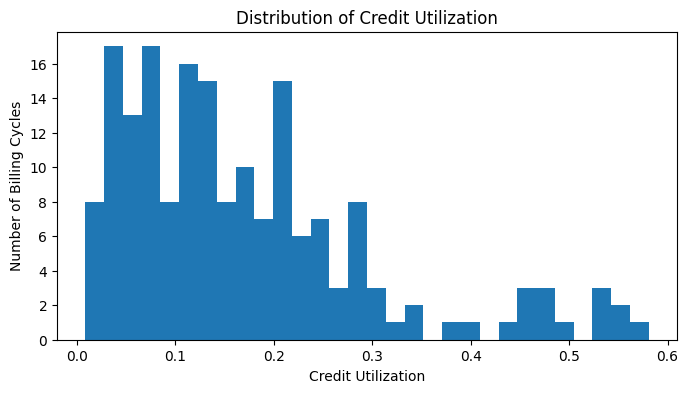

In [12]:
plt.figure(figsize=(8, 4))
plt.hist(cycles_enriched["credit_utilization"], bins=30)
plt.xlabel("Credit Utilization")
plt.ylabel("Number of Billing Cycles")
plt.title("Distribution of Credit Utilization")
plt.show()


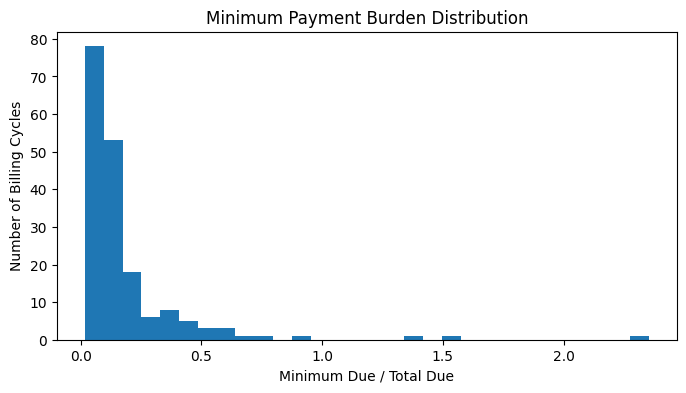

In [13]:
cycles_enriched["min_due_ratio"] = (
    cycles_enriched["minimum_due"] / cycles_enriched["total_due"]
)

plt.figure(figsize=(8, 4))
plt.hist(cycles_enriched["min_due_ratio"], bins=30)
plt.xlabel("Minimum Due / Total Due")
plt.ylabel("Number of Billing Cycles")
plt.title("Minimum Payment Burden Distribution")
plt.show()


In [14]:
def utilization_bucket(u):
    if u < 0.3:
        return "low"
    elif u < 0.6:
        return "medium"
    elif u < 0.9:
        return "high"
    else:
        return "critical"

cycles_enriched["util_bucket"] = cycles_enriched["credit_utilization"].apply(utilization_bucket)


In [15]:
cycles_enriched["util_bucket"].value_counts(normalize=True)


util_bucket
low       0.888889
medium    0.111111
Name: proportion, dtype: float64

In [16]:
cycles_enriched.groupby("util_bucket")[["total_due", "minimum_due"]].mean()


,total_due,minimum_due
util_bucket,,
low,14601.78125,1703.78125
medium,22693.25000,1937.50000


In [17]:
cycles_enriched = cycles_enriched.sort_values(
    ["card_id", "cycle_end_date"]
)


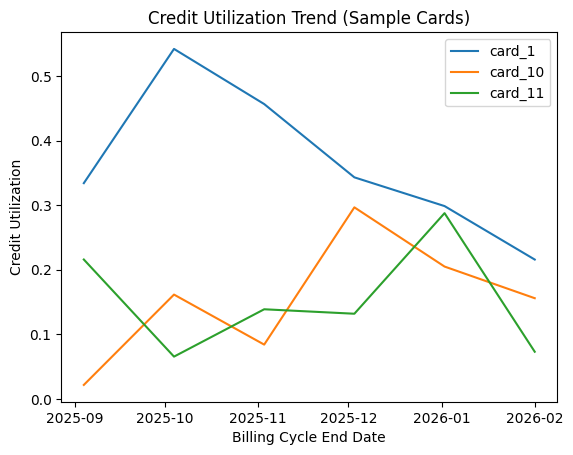

In [18]:
sample_cards = cycles_enriched["card_id"].unique()[:3]

for card in sample_cards:
    card_data = cycles_enriched[cycles_enriched["card_id"] == card]
    plt.plot(card_data["cycle_end_date"], card_data["credit_utilization"], label=card)

plt.legend()
plt.title("Credit Utilization Trend (Sample Cards)")
plt.xlabel("Billing Cycle End Date")
plt.ylabel("Credit Utilization")
plt.show()


## 2. Data Sources

# Week 3 · Day 3 — Transaction & Expense Behavior

Focus:
- Spending patterns
- Category distribution
- Volatility and instability


In [19]:
txns = pd.read_csv(
    "../data/raw/transactions.csv",
    parse_dates=["transaction_date"]
)

txns.head(), txns.shape


(   transaction_id card_id transaction_date  amount merchant_category  \
 0  txn_card_1_0_0  card_1       2026-01-02    1000              rent   
 1  txn_card_1_0_1  card_1       2026-01-04    1000     food_delivery   
 2  txn_card_1_0_2  card_1       2026-01-13     200         utilities   
 3  txn_card_1_0_3  card_1       2026-01-03     100              fuel   
 4  txn_card_1_0_4  card_1       2026-01-18     500     entertainment   
 
   transaction_type  
 0         in_store  
 1         in_store  
 2           online  
 3         in_store  
 4         in_store  ,
 (5908, 6))

In [20]:
txns.isnull().mean()


transaction_id       0.0
card_id              0.0
transaction_date     0.0
amount               0.0
merchant_category    0.0
transaction_type     0.0
dtype: float64

In [21]:
cycle_spend = (
    txns.merge(
        cycles[["billing_cycle_id", "card_id", "cycle_start_date", "cycle_end_date"]],
        on="card_id",
        how="left"
    )
    .query("transaction_date >= cycle_start_date and transaction_date <= cycle_end_date")
    .groupby("billing_cycle_id")["amount"]
    .sum()
    .reset_index(name="monthly_spend")
)

cycle_spend.head()


,billing_cycle_id,monthly_spend
0,card_10_0,23200
1,card_10_1,25800
2,card_10_2,31100
3,card_10_3,35100
4,card_10_4,22900


In [22]:
cycle_spend = (
    txns.merge(
        cycles[["billing_cycle_id", "card_id", "cycle_start_date", "cycle_end_date"]],
        on="card_id",
        how="left"
    )
    .query("transaction_date >= cycle_start_date and transaction_date <= cycle_end_date")
    .groupby("billing_cycle_id")["amount"]
    .sum()
    .reset_index(name="monthly_spend")
)

cycle_spend.head()


,billing_cycle_id,monthly_spend
0,card_10_0,23200
1,card_10_1,25800
2,card_10_2,31100
3,card_10_3,35100
4,card_10_4,22900


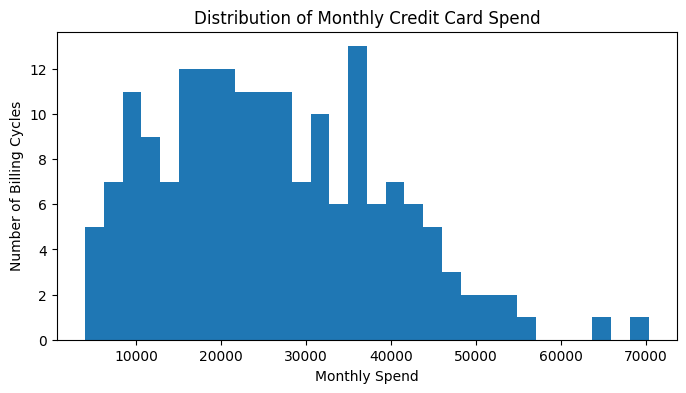

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(cycle_spend["monthly_spend"], bins=30)
plt.xlabel("Monthly Spend")
plt.ylabel("Number of Billing Cycles")
plt.title("Distribution of Monthly Credit Card Spend")
plt.show()


In [24]:
category_dist = (
    txns.groupby("merchant_category")["amount"]
    .sum()
    .sort_values(ascending=False)
)

category_dist


merchant_category
entertainment    608800
fuel             606000
groceries        603100
food_delivery    590300
utilities        568700
rent             562600
shopping         517800
travel           510400
Name: amount, dtype: int64

In [25]:
category_cycle = (
    txns.merge(
        cycles[["billing_cycle_id", "card_id", "cycle_start_date", "cycle_end_date"]],
        on="card_id",
        how="left"
    )
    .query("transaction_date >= cycle_start_date and transaction_date <= cycle_end_date")
    .groupby(["billing_cycle_id", "merchant_category"])["amount"]
    .sum()
    .reset_index()
)

top_category_share = (
    category_cycle
    .groupby("billing_cycle_id")["amount"]
    .apply(lambda x: x.max() / x.sum())
)

top_category_share.describe()


count    180.000000
mean       0.318562
std        0.092729
min        0.174497
25%        0.253351
50%        0.294118
75%        0.365213
max        0.648536
Name: amount, dtype: float64

In [26]:
card_volatility = (
    txns.groupby(["card_id", txns["transaction_date"].dt.to_period("M")])["amount"]
    .sum()
    .groupby("card_id")
    .std()
    .reset_index(name="spend_volatility")
)

card_volatility.head()


,card_id,spend_volatility
0,card_1,15156.736676
1,card_10,8516.728636
2,card_11,11593.403297
3,card_12,4569.317965
4,card_13,17433.836831


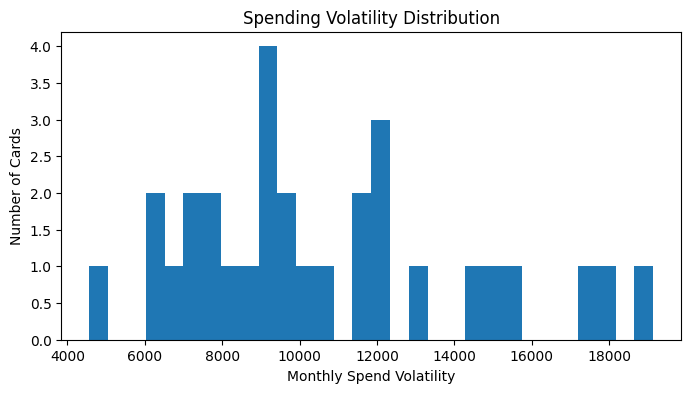

In [27]:
plt.figure(figsize=(8, 4))
plt.hist(card_volatility["spend_volatility"].dropna(), bins=30)
plt.xlabel("Monthly Spend Volatility")
plt.ylabel("Number of Cards")
plt.title("Spending Volatility Distribution")
plt.show()


## 3. Data Loading

## 4. Schema Validation

## 5. Missing Values & Data Quality

## 6. Time Coverage & Granularity

# Week 3 · Day 4 — Time-Series Risk Signals

Focus:
- Trend detection
- Behavioral acceleration
- Early warning indicators


In [28]:
ts_data = cycles_enriched.merge(
    cycle_spend, on="billing_cycle_id", how="left"
)

ts_data = ts_data.sort_values(
    ["card_id", "cycle_end_date"]
)

ts_data.head()


,billing_cycle_id,card_id,cycle_start_date,cycle_end_date,statement_date,due_date,total_due,minimum_due,credit_limit,credit_utilization,min_due_ratio,util_bucket,monthly_spend
0,card_1_5,card_1,2025-08-05,2025-09-04,2025-09-05,2025-09-25,16707,1996,50000,0.33414,0.119471,medium,25800
1,card_1_4,card_1,2025-09-04,2025-10-04,2025-10-05,2025-10-25,27105,2538,50000,0.54210,0.093636,medium,27500
2,card_1_3,card_1,2025-10-04,2025-11-03,2025-11-04,2025-11-24,22834,2163,50000,0.45668,0.094727,medium,9600
3,card_1_2,card_1,2025-11-03,2025-12-03,2025-12-04,2025-12-24,17157,2481,50000,0.34314,0.144606,medium,40200
4,card_1_1,card_1,2025-12-03,2026-01-02,2026-01-03,2026-01-23,14931,1863,50000,0.29862,0.124774,low,48300


In [29]:
ts_data["util_roll_3"] = (
    ts_data.groupby("card_id")["credit_utilization"]
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


In [30]:
ts_data["util_change"] = (
    ts_data.groupby("card_id")["credit_utilization"]
    .diff()
)


In [31]:
ts_data["spend_roll_3"] = (
    ts_data.groupby("card_id")["monthly_spend"]
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


In [32]:
ts_data["spend_shock"] = (
    ts_data["monthly_spend"] > 1.5 * ts_data["spend_roll_3"]
)


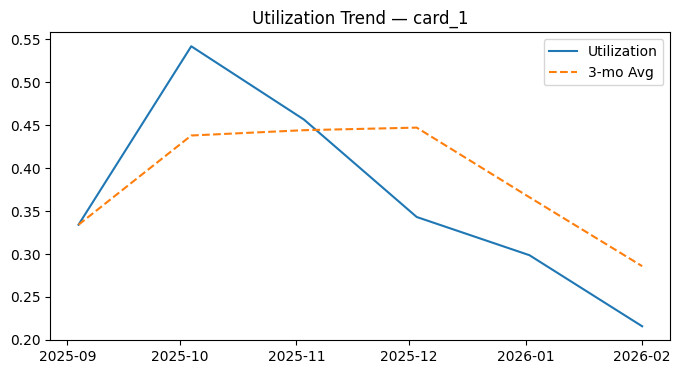

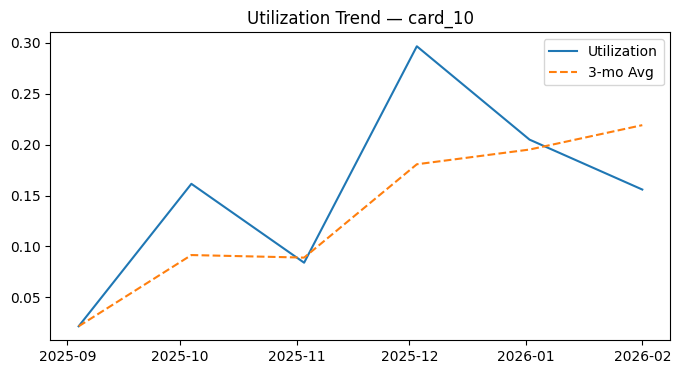

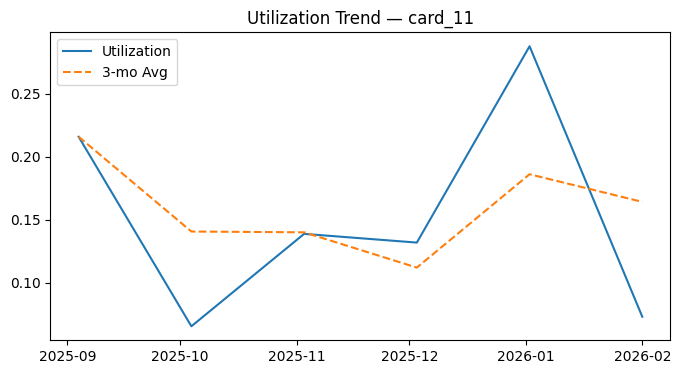

In [33]:
sample_cards = ts_data["card_id"].unique()[:3]

for card in sample_cards:
    card_df = ts_data[ts_data["card_id"] == card]
    
    plt.figure(figsize=(8, 4))
    plt.plot(card_df["cycle_end_date"], card_df["credit_utilization"], label="Utilization")
    plt.plot(card_df["cycle_end_date"], card_df["util_roll_3"], linestyle="--", label="3-mo Avg")
    plt.title(f"Utilization Trend — {card}")
    plt.legend()
    plt.show()


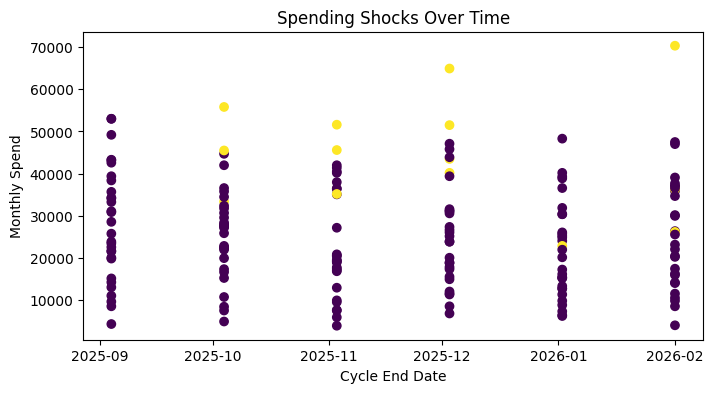

In [34]:
plt.figure(figsize=(8, 4))
plt.scatter(
    ts_data["cycle_end_date"],
    ts_data["monthly_spend"],
    c=ts_data["spend_shock"]
)
plt.title("Spending Shocks Over Time")
plt.xlabel("Cycle End Date")
plt.ylabel("Monthly Spend")
plt.show()


# Week 3 · Day 5 — Target Leakage & Data Validation

Focus:
- Observation vs outcome windows
- Feature timestamp correctness
- Leakage prevention before modeling


### Observation Cutoff Principle

For each billing cycle:
- Features use data ≤ cycle_end_date
- Outcomes (labels) occur AFTER due_date
- Any feature using post-due-date data is leakage

This notebook validates that all current features
respect this temporal boundary.


2.1 Transactions respect cycle boundaries

So, Understanding is that each transaction can belong to oly one billing_cycle. So it should be many to one relation. But the below logic checks if the transaction is outside any billing cycle? instead of checking whether each transaction belongs to one billing_cycle. So you need to change the logic to
valid_transaction ⇔
∃ billing_cycle such that
cycle_start ≤ transaction_date ≤ cycle_end


In [35]:
txn_leak_check = txns.merge(
    cycles[["billing_cycle_id", "card_id", "cycle_start_date", "cycle_end_date"]],
    on="card_id",
    how="left"
)

invalid_txns = txn_leak_check[
    (txn_leak_check["transaction_date"] < txn_leak_check["cycle_start_date"]) |
    (txn_leak_check["transaction_date"] > txn_leak_check["cycle_end_date"])
]

invalid_txns.shape


(29380, 9)

In [36]:
txn_cycle_match = txns.merge(
    cycles[["billing_cycle_id", "card_id", "cycle_start_date", "cycle_end_date"]],
    on="card_id",
    how="left"
)

txn_cycle_match["belongs_to_cycle"] = (
    (txn_cycle_match["transaction_date"] >= txn_cycle_match["cycle_start_date"]) &
    (txn_cycle_match["transaction_date"] <= txn_cycle_match["cycle_end_date"])
)


In [37]:
txn_validity = (
    txn_cycle_match
    .groupby("transaction_id")["belongs_to_cycle"]
    .any()
)
txn_validity.value_counts()



belongs_to_cycle
True    5908
Name: count, dtype: int64

2.2 Rolling features only use past data

In [38]:
ts_data.groupby("card_id")[["credit_utilization", "util_roll_3"]].head()


,credit_utilization,util_roll_3
0,0.33414,0.334140
1,0.54210,0.438120
2,0.45668,0.444307
3,0.34314,0.447307
4,0.29862,0.366147
...,...,...
174,0.03049,0.030490
175,0.17371,0.102100
176,0.26199,0.155397
177,0.23671,0.224137


In [39]:
(ts_data.groupby("card_id")["cycle_end_date"].diff().dropna() > pd.Timedelta(0)).all()


np.True_

Simulate a leakage example

In [40]:
# ❌ This is leakage — DO NOT USE
ts_data["future_utilization"] = (
    ts_data.groupby("card_id")["credit_utilization"].shift(-1)
)


The feature `future_utilization` uses information from the next billing cycle.
This would artificially inflate model performance and is a classic example
of target leakage. Such features are explicitly excluded.


So we are not predicting per transaction
We are not predicting per user

We are predicting:

Risk of a specific billing cycle, using only information available before its due date

That is exactly how real credit risk systems work.

# Week 3 · Day 6 — Segment Analysis & Risk Profiling

Focus:
- Behavioral segmentation
- Stable vs risky profiles
- Feature hypotheses for modeling


Define segments
We’ll segment on meaningful, pre-label signals.

1.1 Utilization-based segments

In [41]:
segments = ts_data.copy()

segments["util_segment"] = segments["credit_utilization"].apply(
    lambda u: "low" if u < 0.3 else ("medium" if u < 0.6 else "high")
)


1.2 Volatility-based segments
Spending volatility = variability in spending over time
card_volatility= For each card, how much does its monthly spending fluctuate?
Card_volatility will tell you these below characterstics:
Low value → very consistent spender

High value → unpredictable spender
Hence we segment these users

In [42]:
segments = segments.merge(
    card_volatility, on="card_id", how="left"
)

segments["vol_segment"] = pd.qcut(
    segments["spend_volatility"],
    q=3,
    labels=["stable", "moderate", "volatile"]
)
segments[["util_segment", "vol_segment"]].value_counts()


util_segment  vol_segment
low           stable         57
              moderate       52
              volatile       51
medium        volatile        9
              moderate        8
              stable          3
Name: count, dtype: int64

What is segments at this point?
segments already contains:
card_id
billing_cycle info
credit_utilization
monthly_spend
utilization segment (low / medium / high)

But it does NOT yet know:
whether the card is stable or volatile across time

Volatility is:
card-level
computed across months

So we attach that card-level property to every billing cycle of that card.

Why how="left"?
Because:
Every billing cycle belongs to a card
Some cards might (in theory) lack volatility (edge cases)
We never want to drop billing cycles

So:
“Keep all billing cycles, attach volatility where available.”

4.3 What does pd.qcut actually do?

Internally, Pandas:
Sorts spend_volatility
Finds cut points at 33% and 66%
Assigns each row to a bin

Example (simplified):
Volatility values:
[200, 300, 500, 900, 1200, 3000]
Sorted:
[200, 300 | 500, 900 | 1200, 3000]


Segments:
stable → lowest third
moderate → middle third
volatile → highest third

4.4 Why labels = ["stable", "moderate", "volatile"]?
This is interpretability.
Instead of:
vol_segment = 0, 1, 2
We get:
vol_segment = stable / moderate / volatile

Compare behavior across segments

In [43]:
segments.groupby("util_segment")[["monthly_spend", "credit_utilization"]].mean()


,monthly_spend,credit_utilization
util_segment,,
low,26355.0,0.134154
medium,23245.0,0.453865


Interpret:

Do high-util users also spend more?

Or are they constrained spenders?

2.2 Volatility vs utilization

In [44]:
segments.groupby("vol_segment")[["credit_utilization", "monthly_spend"]].mean()


,credit_utilization,monthly_spend
vol_segment,,
stable,0.153546,24488.333333
moderate,0.200764,24775.000000
volatile,0.154722,28765.000000


Profile “Stable” vs “Risky” archetypes

In [45]:
stable_profile = segments[
    (segments["util_segment"] == "low") &
    (segments["vol_segment"] == "stable")
]

risky_profile = segments[
    (segments["util_segment"] == "high") |
    (segments["vol_segment"] == "volatile")
]

stable_profile.shape, risky_profile.shape


((57, 21), (60, 21))

In [46]:
stable_profile[["monthly_spend", "spend_shock"]].mean()
risky_profile[["monthly_spend", "spend_shock"]].mean()


monthly_spend    28765.000000
spend_shock          0.116667
dtype: float64

Visual comparison
4.1 Utilization by segment

<Figure size 800x400 with 0 Axes>

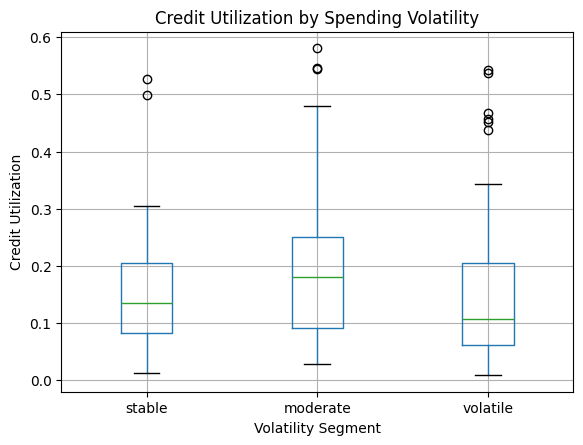

In [47]:
plt.figure(figsize=(8, 4))
segments.boxplot(column="credit_utilization", by="vol_segment")
plt.title("Credit Utilization by Spending Volatility")
plt.suptitle("")
plt.xlabel("Volatility Segment")
plt.ylabel("Credit Utilization")
plt.show()


4.2 Spend by utilization segment

<Figure size 800x400 with 0 Axes>

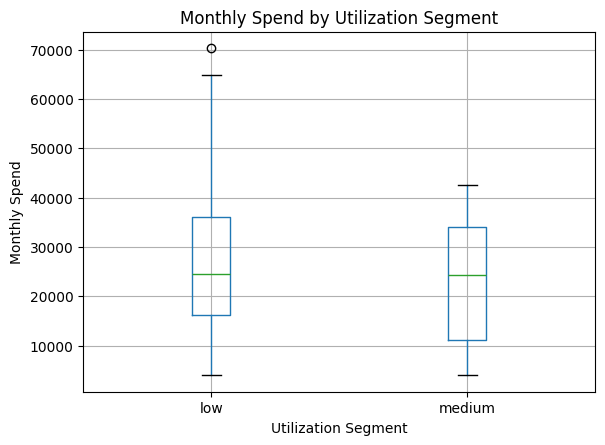

In [48]:
plt.figure(figsize=(8, 4))
segments.boxplot(column="monthly_spend", by="util_segment")
plt.title("Monthly Spend by Utilization Segment")
plt.suptitle("")
plt.xlabel("Utilization Segment")
plt.ylabel("Monthly Spend")
plt.show()


|---- Billing Cycle ----| Statement | Due Date |---- Outcome Window ----|
^                       ^           ^           ^
cycle_start         cycle_end   due_date   due_date + 30/60/90


In [49]:
(cycles["due_date"] > cycles["cycle_end_date"]).all()


np.True_

In [52]:
features = pd.read_csv("../data/processed/features.csv")
labels = pd.read_csv("../data/processed/labels.csv")

cycles = pd.read_csv(
    "../data/raw/billing_cycles.csv",
    parse_dates=["cycle_start_date", "cycle_end_date", "due_date"]
)


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/features.csv'

In [53]:
features = ts_data[[
    "billing_cycle_id",
    "credit_utilization",
    "min_due_ratio",
    "monthly_spend",
    "spend_volatility",
    "util_roll_3",
    "spend_roll_3",
    "spend_shock"
]].copy()

features.to_csv("../data/processed/features.csv", index=False)


KeyError: "['spend_volatility'] not in index"